In [1]:
## Import packages to read in data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as seabornInstance 
import datetime
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer

%matplotlib inline

In [2]:
%%time

## Data does not have column headers, add these when importing

column_labels = ['transaction_ID', 'price', 'transfer_date', 'postcode','property_type', 
              'new_build','duration', 'PAON', 'SAON', 'street', 'locality', 'town_city', 
              'district', 'county', 'PPD_category_type', 'record_status']

## Read in the UK Housing Prices Paid 2018 dataset
## requires chunking as it is a large file

df_chunk = pd.read_csv("/Users/user/Desktop/Datasets/pp-2018.csv", names=column_labels,
                      iterator=True, chunksize=10000)

## concatenate the chunks into one DataFrame 
chunk_list = []  # append each chunk here 

# Each chunk is in df format
for chunk in df_chunk:      
    # Once the data filtering is done, append the chunk to list
    chunk_list.append(chunk)
    
# concat the list into dataframe 
df = pd.concat(chunk_list)

CPU times: user 8.33 s, sys: 1.57 s, total: 9.91 s
Wall time: 11.9 s


In [3]:
## As we are interested in only selected columns, restructure the data for these columns
## exclude transaction ID, secondary address (SAON), PPD category type, and record status
df = df.drop(columns = ['transaction_ID', 'SAON', 'PPD_category_type', 'record_status'])

In [4]:
## Convert transfer date to DateTime object
df['transfer_date'] = pd.to_datetime(df.transfer_date)

## Add month and year columns
df['month'] = df['transfer_date'].dt.month
df['year'] = df['transfer_date'].dt.year

df.describe()

,price,month,year
count,1.023150e+06,1.023150e+06,1023150.0
mean,3.497070e+05,6.775684e+00,2018.0
std,1.876659e+06,3.371084e+00,0.0
min,1.000000e+00,1.000000e+00,2018.0
25%,1.450000e+05,4.000000e+00,2018.0
50%,2.300000e+05,7.000000e+00,2018.0
75%,3.550000e+05,1.000000e+01,2018.0
max,5.692000e+08,1.200000e+01,2018.0


### Summary of key statistics

Total number of homes sold in 2018: 1,023,150
Overall 2018 average price was : £349,707
Overall 2018 median price was : £230,000
Average 2018 price paid in London was: £1,019,656


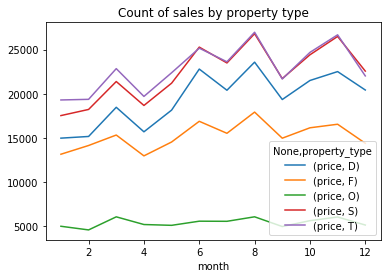

In [5]:
## Summary statistics of dataset
avg_price = np.mean(df.price)
median_price = np.median(df.price)
year_select = 2018
sales_count = len(df.year == year_select)

## Key summary statistics and print out
print("Total number of homes sold in " + str(year_select) + ": " + format(sales_count, ","))
print("Overall 2018 average price was : £" + format(avg_price, ",.0f"))
print("Overall 2018 median price was : £" + format(median_price, ",.0f"))

## Average price paid in London
city_select = 'London'
avg_price_paid = round(df[df.town_city == city_select.upper()].price.mean(), 2)
print("Average 2018 price paid in " + city_select + " was: £" + format(avg_price_paid, ",.0f"))

## Graphing homes sold over time during the year
count_by_month = df[['month','property_type','price']].groupby(['month', 'property_type']).count()
count_by_month = count_by_month.unstack().plot(kind='line', legend=True, 
                                               title='Count of sales by property type')

### Viewing the dataset by selecting criteria

In [6]:
## Explore the data with different criteria
criteria01 = df.price > 1000000
criteria02 = df.new_build == 'Y'

## Return a table, with selected columns, based on those criteria
df_query = df[criteria01 & criteria02].reset_index()
df_query[['price', 'property_type', 'new_build', 'town_city']].head()

,price,property_type,new_build,town_city
0,1325000,D,Y,BISHOP'S STORTFORD
1,1250000,D,Y,HARPENDEN
2,1425000,D,Y,BISHOP'S STORTFORD
3,1150000,F,Y,WINCHESTER
4,1200000,D,Y,BISHOP'S STORTFORD


In [133]:
## Count and sort the number of properties sold by city, create a top 10 list

from collections import Counter

cities_list = df.town_city

cities_count = Counter(cities_list)
cities_ranked = pd.DataFrame.from_dict(cities_count, orient='index').reset_index()
cities_ranked.columns = ['town_city', 'sales_count']
cities_ranked = cities_ranked.sort_values('sales_count', ascending=False).reset_index(drop=True)

cities_top10 = cities_ranked[:10]
cities_top10

,town_city,sales_count
0,LONDON,66191
1,MANCHESTER,18089
2,BIRMINGHAM,16227
3,BRISTOL,15884
4,NOTTINGHAM,14060
5,LIVERPOOL,13659
6,LEEDS,11947
7,SHEFFIELD,10133
8,LEICESTER,9381
9,SOUTHAMPTON,8172


### Compare multiple cities prices paid

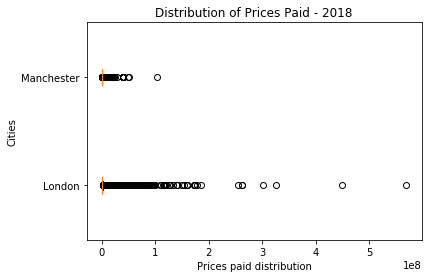

In [8]:
city_option01 = 'London'
city_option02 = 'Manchester'

city01 = df[df['town_city'] == city_option01.upper()]
city02 = df[df['town_city'] == city_option02.upper()]

plt.boxplot([city01.price, city02.price], labels=[city_option01, city_option02], 
            autorange=True, widths=0.15, vert=False)
plt.title('Distribution of Prices Paid - 2018')
plt.xlabel('Prices paid distribution')
plt.ylabel('Cities')
plt.show()

### For predictive modelling, first we will preprocess the data to ensure it can by properly read by the scikit-learn packge. This involves converting ordinal (categorical) data into numerical data.

In [9]:
## Create new columns to enumerate the string data in Property Type and New Build columns
#prep_prop_type = {'D' : 1, 
#                  'S' : 2, 
#                  'T' : 3, 
#                  'F' : 4, 
#                  'O' : 5}

#prep_new_build = {'N': 0, 
#                  'Y': 1}

#df['prep_prop_type'] = [prep_prop_type[x] for x in df.property_type]
#df['prep_new_build'] = [prep_new_build[x] for x in df.new_build]

In [196]:
## Create a new dataframe with only data from the top 10 cities by sales counts

top_ten = cities_top10['town_city']

df_ten = df[df.town_city.isin(top_ten)]
        
len(df_ten)

183743

### Also, we need to generalize the postcodes by removing the last 3 letters to provide a better geographical grouping (6-7 character postcodes are overly specific)

In [209]:
build_type = df_ten['new_build']
prop_type = df_ten['property_type']
cityID = df_ten['town_city']

xencode = LabelEncoder()
build_type = xencode.fit_transform(build_type)
xkeys = xencode.classes_
xkeys = list(xkeys)

yencode = LabelEncoder()
prop_type = yencode.fit_transform(prop_type)
ykeys = yencode.classes_
ykeys = list(ykeys)

zencode = LabelEncoder()
cityID = zencode.fit_transform(cityID)
zkeys = zencode.classes_
zkeys = list(zkeys)

cols = xkeys + ykeys + zkeys
cols

['N',
 'Y',
 'D',
 'F',
 'O',
 'S',
 'T',
 'BIRMINGHAM',
 'BRISTOL',
 'LEEDS',
 'LEICESTER',
 'LIVERPOOL',
 'LONDON',
 'MANCHESTER',
 'NOTTINGHAM',
 'SHEFFIELD',
 'SOUTHAMPTON']

In [197]:
build_type = pd.DataFrame(build_type)
prop_type = pd.DataFrame(prop_type)
cityID = pd.DataFrame(cityID)
data = pd.concat([build_type, prop_type, cityID], axis=1)
len(data)

183743

In [207]:
data_ohe = OneHotEncoder().fit_transform(data).toarray()
z = pd.DataFrame(data_ohe)

z.columns = cols
z['price'] = df_ten.price
z.dropna()
len(z)

183743

### Assign the data to the scikit-learn packages, starting with Decision Trees

In [211]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

feature_cols = cols

X = z[feature_cols] #features
y = z.price #target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

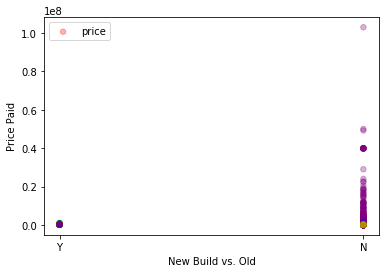

In [68]:
# City for graph
city = 'Manchester'

# number representing size
x1 = df[df['town_city'] == city.upper()].new_build

# generate array of property types
x2 = df[df['town_city'] == city.upper()].property_type

# number representing price
y = df[df['town_city'] == city.upper()].price

# create mapping from property type to matplot colour
property_type_colour_map = {'D' : 'blue', 
                            'S' : 'red', 
                            'T' : 'yellow', 
                            'F' : 'green', 
                            'O' : 'purple'}

# create array of colours from list comprehension
colour_array = [property_type_colour_map[i] for i in x2]

plt.scatter(x1, y, c=colour_array, alpha=0.3, s=30)
plt.xticks()
plt.yticks()
plt.xlabel('New Build vs. Old')
plt.ylabel('Price Paid')
plt.legend()
plt.show()